# Generative model assignment

After training a network to calssify an image we can use it to generate images for our classes.
This sounds like magic but it is just a matter of running the network *backwards* instead of *forwards*.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats

In [25]:
def display_image(im):
    plt.imshow(im.reshape((28, 28)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    
def fully_connected(ninputs, noutputs):
    boundary = np.sqrt(6 / (ninputs + noutputs))
    return np.random.uniform(-boundary, boundary, size=(ninputs, noutputs))

def softmax(x):
    expx = np.exp(x - x.max(axis=1, keepdims=True))
    return expx / expx.sum(axis=1, keepdims=True)

def accuracy(Yhat, Y):
    return (Y.argmax(axis=1) == Yhat.argmax(axis=1)).mean()

def cross_entropy(Yhat, Y):
    ylogy = Y * np.log(Yhat)
    return -ylogy.sum()

def predict(Ws, X):
    if X.ndim == 1:
        X = X[np.newaxis, :]
    return feed_forward(Ws, X, keep_prob=1)[-1]

def display_prediction(idx=None):
    if idx is None:
        idx = np.random.randint(0, X_test.shape[0])
    print(predict(Ws, X_test[idx, :]).argmax())
    return display_image(X_test[idx, :].reshape(28, 28))

def drop(X, keep_prob=1):
    if keep_prob < 1:
        X = X.copy() # we don't want to change X
        keeps = np.random.rand(X.shape[1]) < keep_prob
        # X.shape is (nsamples, nfeatures)
        X[:, ~keeps] = 0 # ignore
        X[:, keeps] *= (1/keep_prob) # normalize
    return X

def average(prev, curr, β):
    return [
        β * p + (1 - β) * c
        for p, c
        in zip(prev, curr)
    ]


class Trainer:
    def __init__(self, X, Y, batch_size=50, η=0.001, keep_prob=0.5):
        self.X = X
        self.Y = Y
        self.epochs = 0
        self.batches = 0
        self.batch_size = batch_size
        self.η = η
        self.nsamples = X.shape[0]
        self.keep_prob = keep_prob
        self.optimizer = AdamOptimizer()
        
    def train(self, Ws):
        self.batches += 1
        self.epochs = self.batches * self.batch_size // self.nsamples
        # get next batch
        start = (self.batches * self.batch_size) % self.nsamples
        stop = start + self.batch_size
        batch_idx = range(start, stop)
        X_, Y_ = self.X[batch_idx, :], self.Y[batch_idx, :]
        # calculate gradients
        dWs = back_propagation(Ws, X_, Y_, keep_prob=self.keep_prob)
        # calculate updates
        ΔWs = self.optimizer.send(dWs)        
        # apply updates in place
        # apply updates
        for W, ΔW in zip(Ws, ΔWs):
            W += ΔW
            

class AdamOptimizer:
    def __init__(self, α=0.001, β1=0.9, β2=0.999, ϵ=1e-8):
        self.α = α
        self.β1 = β1
        self.β2 = β2
        self.ϵ = ϵ
        self.m = None
        self.v = None
        self.t = 0

    def send(self, gradients):
        if self.m is None:
            self.m = [0] * len(gradients)
        if self.v is None:
            self.v = [0] * len(gradients)

        self.t += 1
        αt = self.α * np.sqrt(1 - self.β2**self.t) / (1 - self.β1**self.t)
        self.m = average(self.m, gradients, self.β1)        
        self.v = average(self.v, (g*g for g in gradients), self.β2)

        updates = [-αt * mi / (np.sqrt(vi) + self.ϵ) for mi, vi in zip(self.m, self.v)]
        for upd in updates:
            assert np.isfinite(upd).all()
        return updates

# Hyperbolic tangent

A technical detail is that ReLU is irreversible, as all negative numbers go to 0.
So we will quickly replace it with `tanh`, the [hyperbolic tangent function, tanh](https://en.wikipedia.org/wiki/Hyperbolic_tangent), which is inversible and has an easy to calculate derivative.

In [4]:
tanh = np.tanh
atanh = np.arctanh

def dtanh(X):
    return 1 - tanh(X)**2

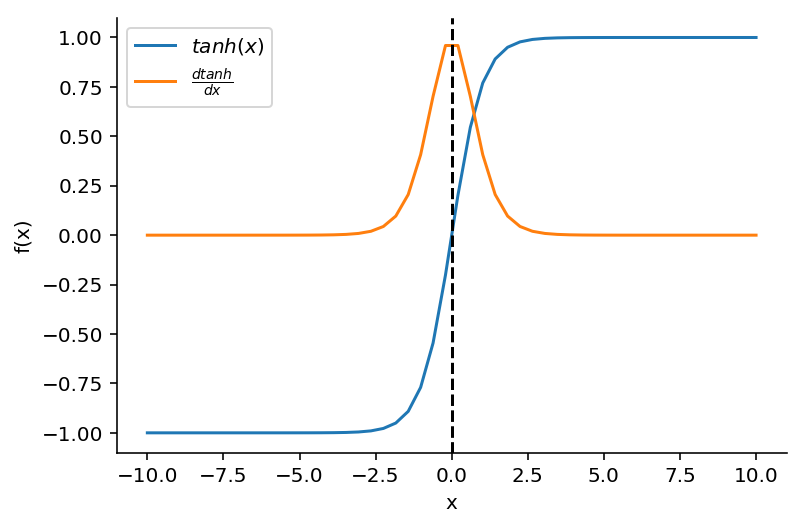

In [5]:
xrange = np.linspace(-10, 10)
plt.plot(xrange, tanh(xrange), label='$tanh(x)$')
plt.plot(xrange, dtanh(xrange), label=r'$\frac{d tanh}{dx}$')
plt.axvline(0, ls='--', color='k')
plt.axvline(0, ls='--', color='k')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
sns.despine()

# Load data

In [6]:
import keras
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
nsamples, width, height = X_train.shape
nfeatures = width * height
X_train = X_train.reshape(nsamples, nfeatures)
X_test = X_test.reshape(-1, nfeatures)
Y_train = keras.utils.to_categorical(Y_train)
Y_test = keras.utils.to_categorical(Y_test)
ncats = Y_test.shape[1]

Using TensorFlow backend.


# Feed and propagate

1) Re-implement `feed_forward` and `back_propagation` from [the FFN seesion](FFN.ipynb) to use tanh instead of ReLU, then create a new network and fit it to the data.

In [11]:
def feed_forward(Ws, X, keep_prob=1):
    pass


def back_propagation(Ws, X, Y, keep_prob=1):
    pass

In [18]:
# comment out the %run line to use your code
%run -i ../solutions/FFN_GenModel.py 
W1 = fully_connected(nfeatures, 1000)
W2 = fully_connected(1000, ncats)
Ws = [W1, W2]
t = 0
train = Trainer(X_train, Y_train)

In [ ]:
trainer = Trainer(X_train, Y_train)
while trainer.epochs < 5:
    trainer.train(Ws)

In [ ]:
if input("Are you sure?") == 'y':
    np.savez_compressed('../data/FFN_MNIST_2layer_tanh.npz', Ws=Ws)

2


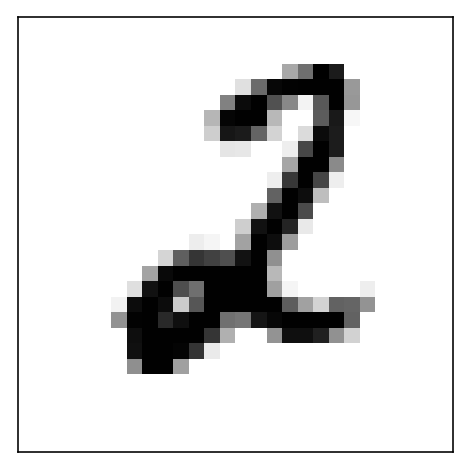

In [26]:
with np.load('../data/FFN_MNIST_2layer_tanh.npz') as d:
    Ws = d['Ws']

display_prediction()

# Feed backwards: imagine!

2) Implement a `feed_backward` function.

`feed_backward` receives `Ws` and `Yhat`, an array of length 10 with probabilities for each of the digits 0 through 9.
It iterates back through the network, at each step inversing the activation function (either softmax or tanh) and the matrix multiplication (by right-multiplying with the transpose of `W`)
The result is the input layer `X_1` with 728 pixels per sample.

Note that we already loaded the `arctanh` function which is the reverse of `tanh`.

In [59]:
def feed_backward(Ws, Yhat):
    pass

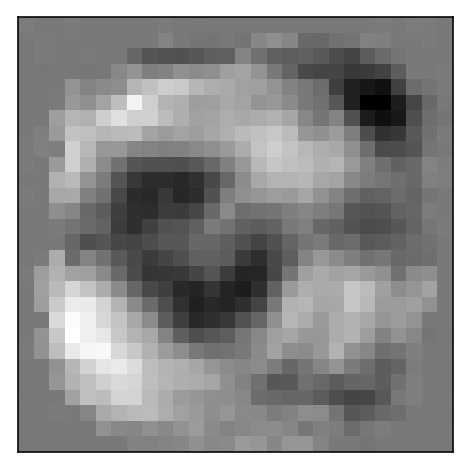

In [27]:
# comment out this line to use your code and/or fitted model
%run -i ../solutions/FFN_GenModel.py
with np.load('../data/FFN_MNIST_2layer_tanh.npz') as d:
    Ws = d['Ws']

def generate(Ws, y):
    return feed_backward(Ws, y).reshape(28, 28)

number = 3
y = np.ones(10) * 1e-7
y[number] = 1 - y.sum()
x = generate(Ws, y)
display_image(x)